See http://winvector.github.io/freq/minimax.pdf for background and details

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
# install.packages('ggplot2',repos='http://cran.us.r-project.org')
library(ggplot2)
library(reshape2)

In [3]:
import sympy
import numpy
import pandas
import scipy
import scipy.special
import scipy.optimize
import cvxopt

In [4]:
def ncr(n,h):
    return int(sympy.binomial(k,h))

def numericSoln(si):
    return { k:complex(si[k]).real for k in si.keys() }

def printsolnN(phis,soln):
   ns = numericSoln(soln)
   for phi in phis:
      if phi in soln:
         print('\t',phi,'\t',soln[phi],'\t',ns[phi])

# optimal l2 loss solution
def l2minimaxSoln(k,numeric=False):
    sqrtk = sympy.sqrt(k)
    if numeric:
        sqrtk = float(sqrtk)
    return [(sqrtk/2 + h)/(sqrtk+k) for h in range(k+1) ]

# approximate l1 loss for using phis as our estimate when prob is one of pseq
def l1Loss(phis,pseq=[ pi/float(1000) for pi in range(1001) ]):
    k = len(phis)-1
    kchoose = [ float(ncr(k,h)) for h in range(k+1) ]
    def f(p):
        if p<0 or p>1:
            return float('inf')
        return sum([ p**h * (1.0-p)**(k-h) * kchoose[h] * abs(phis[h]-p) for h in range(k+1) ])
    reg = max([ f(p) for p in pseq ])
    return reg

# approximate l2 loss for using phis as our estimate when prob is one of pseq
def l2Loss(phis,pseq):
    k = len(phis)-1
    kchoose = [ float(ncr(k,h)) for h in range(k+1) ]
    def f(p):
        if p<0 or p>1:
            return float('inf')
        return sum([ p**h * (1.0-p)**(k-h) * kchoose[h] * (phis[h]-p)**2 for h in range(k+1) ])
    reg = max([ f(p) for p in pseq ])
    return reg

def solveL2Problem(k,pseq):
    baseSoln = l2minimaxSoln(k,numeric=True)
    l0 = l2Loss(baseSoln,pseq)
    maxP = max(pseq)
    minP = min(pseq)
    start = [ min(maxP,max(minP,phi)) for phi in baseSoln ]
    def f(x):
        if not all([ phi>=0 and phi<=1 for phi in x]):
            return l0+1.0
        return l2Loss(x,pseq)
    opt = scipy.optimize.minimize(f,start,method='Powell')
    return opt['x']



# Solve argmin_phi max_i sum_{j=0}^{k} (k choose j) p(i)^j (1-p(i))^{k-j} | p(i) - phi(j) |
# Pick set of estimates (indexed by evidence) minimizing worse L1 loss expected for any p
# k: number of flips
# p: set of probabilities to check against
def solveL1Problem(k,p):
   nphis = k+1
   p = list(set(p))
   nps = len(p)
   # encode argmin_phi max_i sum_{j=0}^{k} (k choose j) p(i)^j (1-p(i))^{k-j} | p(i) - phi(j) |
   # solve a x <= b 
   # varibles: 
   #  phi (indices: 0 ... nphis-1)
   #  u (indices: nphis ... (1+nps)*nphis-1) 
   #   u(i,j) = var((i+1)*nphis+j) = abs(phi(j)-p(i)) i=0...nps-1, j=0...nphis-1
   #  s (index: (1+nps)*nphis )
   # eqns: 
   #  u(i,j) >= phi(j) - p(i)
   #  u(i,j) >= -(phi(j) - p(i))
   #  s >= sum_{j=0}^{k} (k choose j) p(i)^j (1-p(i))^{k-j} u(i,j)
   nvars = (1+nps)*nphis+1
   sindex = (1+nps)*nphis
   a = []
   b = []
   c = numpy.zeros(nvars)
   c[sindex] = 1.0
   for i in range(nps):
      arow = numpy.zeros(nvars)
      brow = 0.0
      # TODO: put poly coefs in terms of u's here
      arow[sindex] = -1.0
      for j in range(nphis):
         uindex = (i+1)*nphis+j
         arow[uindex] = ncr(k,j) * p[i]**j * (1-p[i])**(k-j)
      a.append(arow)
      b.append(brow)
      for j in range(nphis):
         uindex = (i+1)*nphis+j
         phiindex = j
         # u(i,j) >= phi(j) - p(i) : phi(j) - u(i,j) <= p(i)
         arow = numpy.zeros(nvars)
         arow[phiindex] = 1.0
         arow[uindex] = -1.0 
         brow = p[i]
         a.append(arow)
         b.append(brow)
         # u(i,j) >= -(phi(j) - p(i)) : -phi(j) - u(i,j) <= -p(i)
         arow = numpy.zeros(nvars)
         arow[phiindex] = -1.0
         arow[uindex] = -1.0 
         brow = -p[i]
         a.append(arow)
         b.append(brow)
   cmat = cvxopt.matrix(c)
   gmat = cvxopt.matrix(numpy.matrix(a))
   hmat = cvxopt.matrix(b)
   cvxopt.solvers.options['show_progress'] = False
   sol = cvxopt.solvers.lp(cmat,gmat,hmat) # solve gmax * x <= hmat minimizing cmat
   return [ sol['x'][i] for i in range(nphis) ]

# l1 cost on known ps
def l1Cost(phis,ps):
    k = len(phis)-1
    choose = [ ncr(k,j) for j in range(len(phis)) ]
    def f(p):
        return sum([ choose[j] *  p**j * (1.0-p)**(k-j) * abs(phis[j]-p) for j in range(len(phis)) ])
    return max([ f(p) for p in ps ])
        
# solve argmax_p sum_{j=0}^{k} (k choose j) p^j (1-p)^{k-j} | p - phi(j) | for 0<=p<=1
# allowed to return more than one violation
def worstL1ps(phis):
    k = len(phis)-1
    choose = [ ncr(k,j) for j in range(len(phis)) ]
    def f(p):
        return -sum([ choose[j] * p**j * (1-p)**(k-j) * abs(phis[j]-p) for j in range(len(phis)) ])
    cuts = set([0.0,1.0])
    for phi in phis:
        if phi>0.0 and phi<1.0:
            cuts.add(phi)
    cuts = sorted(cuts)
    optX = set()
    optF = None
    for i in range(len(cuts)-1):
       opti = scipy.optimize.minimize_scalar(f,bounds=(cuts[i],cuts[i+1]),method='Bounded')
       xi = opti['x']
       fi = -f(xi)
       optX.add(xi)
       if (optF is None) or (fi>optF):
            optF = fi
    return optX,optF

# return which ps are approximately diverse active constrains on the current phis
def activeL1Constraints(phis,ps):
    ps = list(ps)
    k = len(phis)-1
    choose = [ ncr(k,j) for j in range(len(phis)) ]
    def f(p):
        return sum([ choose[j] *  p**j * (1.0-p)**(k-j) * abs(phis[j]-p) for j in range(len(phis)) ])
    losses = [ f(p) for p in ps ]
    maxloss = max(losses)
    indices = sorted(range(len(losses)),key=lambda i: -losses[i])
    active = set()
    for idx in indices:
        pi = ps[idx]
        lossi = losses[idx]
        if lossi<maxloss-1.0e-6:
            break
        if len(active)<=0 or min([ abs(pi-aj) for aj in active])>1.0e-3:
            active.add(pi)
    return sorted(active)


# solve L1 problem over 0<=p<=1 using crude approximate column generation method
def solveL1ProblemByCuts(k):
   ps = set([ i/100.0 for i in range(101) ])
   done = False
   while not done:
      phis = solveL1Problem(k,ps)
      cost1 = l1Cost(phis,ps)
      ps = ps.union(set(phis))
      newPs,cost2 = worstL1ps(phis)
      ps = ps.union(newPs)
      cost2 = l1Cost(phis,ps)
      if not cost1+1.0e-12<cost2:
         done = True
   return phis,activeL1Constraints(phis,ps)

            
# Build the Bayes estimate of expected values from uniform priors
# on the unknown probability pWin in the set phis
# seen in kFlips trials
def bayesMeansEstimates(phis,priors,kFlips):
  nphis = len(phis)
  if priors is None:
     priors = numpy.ones(nphis)
  else:
     priors = numpy.array(priors)
  priors = priors/sum(priors)
  e = numpy.zeros(kFlips+1)
  for winsSeen in range(kFlips+1):
    posteriorProbs = numpy.zeros(nphis)
    for i in range(nphis):
      pWin = phis[i]
      posteriorProbs[i] = priors[i]*ncr(kFlips,winsSeen) * \
         pWin**winsSeen * (1-pWin)**(kFlips-winsSeen)
    posteriorProbs = posteriorProbs/sum(posteriorProbs)
    e[winsSeen] = sum(posteriorProbs*phis)
  return numpy.array(e)

In [5]:
def reportSoln(x,pTrue):
    return '[' + ' '.join([str(xi) for xi in x]) + '] l2Loss ' + str(l2Loss(x,pTrue)) + ', l1Loss ' + str(l1Cost(x,pTrue))

df = pandas.DataFrame(columns=['n','h','estName','phi'])
df[['n','h']] = df[['n','h']].astype(int)
df[['estName']] = df[['estName']].astype(str)
df[['phi']] = df[['phi']].astype(float)

def addToFrame(n,estName,phis):
    for h in range(len(phis)):
        df.loc[df.shape[0]+1] = [n,h,estName,phis[h]]

for k in range(1,11):
    print('')
    print('solutions for k-rolls:',k)
    obliviousSoln = [0.5 for h in range(k+1)]
    efSoln = [ h/float(k) for h in range(k+1)]
    addToFrame(k,'Frequentist',efSoln)
    print('\tempirical frequentist solution:',efSoln)
    bjSoln = [ (h+0.5)/(k+1.0) for h in range(k+1)]
    addToFrame(k,'Bayes (Jeffreys)',bjSoln)
    print('\tJeffries prior Bayes solution:',bjSoln)
    l1soln,activePs = solveL1ProblemByCuts(k)
    addToFrame(k,'l1 minimax',l1soln)
    print('\tl1 solution for general coin game:',l1soln)
    print('\t\t l1 diffs:',[l1soln[i+1]-l1soln[i] for i in range(len(l1soln)-1)])
    print('\tl1 solution active ps:',activePs)
    l2soln = l2minimaxSoln(k,numeric=True)
    addToFrame(k,'l2 minimax',l2soln)
    print('\tnumeric l2 for general coin game:',l2soln)
    for pTrue in [(0.0,0.5,1.0),(1/6.0,2/6.0,3/6.0,4/6.0,5/6.0)]:
        print('\tsolutions for for k-roll games restricted to probs',pTrue)
        print('\t\tempirical frequentist solution:',reportSoln(efSoln,pTrue))
        print('\t\tobvlivious solution',reportSoln(obliviousSoln,pTrue))
        print('\t\tuniform prior restricted Bayes soln:',reportSoln(bayesMeansEstimates(pTrue,None,k),pTrue))
        print('\t\tl1 solution for restrited dice game:',reportSoln(solveL1Problem(k,pTrue),pTrue))
        l2solnP = solveL2Problem(k,pTrue)
        print('\t\tl2 solution for restrited dice game:',reportSoln(l2solnP,pTrue))
        print('\t\t\tl2 restricted loss of last soln:',l2Loss(l2solnP,pTrue),'(and for general l2 solution)',l2Loss(l2soln,pTrue))
    print


solutions for k-rolls: 1
	empirical frequentist solution: [0.0, 1.0]
	Jeffries prior Bayes solution: [0.25, 0.75]
	l1 solution for general coin game: [0.24999999993052435, 0.7500000000694759]
		 l1 diffs: [0.5000000001389515]
	l1 solution active ps: [0.0, 0.5, 1.0]
	numeric l2 for general coin game: [0.25, 0.75]
	solutions for for k-roll games restricted to probs (0.0, 0.5, 1.0)
		empirical frequentist solution: [0.0 1.0] l2Loss 0.25, l1Loss 0.5
		obvlivious solution [0.5 0.5] l2Loss 0.25, l1Loss 0.5
		uniform prior restricted Bayes soln: [0.166666666667 0.833333333333] l2Loss 0.111111111111, l1Loss 0.333333333333
		l1 solution for restrited dice game: [0.24999999945491402 0.7500000005450856] l2Loss 0.0625000002725429, l1Loss 0.2500000005450858
		l2 solution for restrited dice game: [0.25 0.75] l2Loss 0.0625, l1Loss 0.25
			l2 restricted loss of last soln: 0.0625 (and for general l2 solution) 0.0625
	solutions for for k-roll games restricted to probs (0.16666666666666666, 0.3333333333

[1] "Frequentist"
    h
n            0         1         2         3         4         5         6         7         8         9        10
  1  0.0000000 1.0000000                                                                                          
  2  0.0000000 0.5000000 1.0000000                                                                                
  3  0.0000000 0.3333333 0.6666667 1.0000000                                                                      
  4  0.0000000 0.2500000 0.5000000 0.7500000 1.0000000                                                            
  5  0.0000000 0.2000000 0.4000000 0.6000000 0.8000000 1.0000000                                                  
  6  0.0000000 0.1666667 0.3333333 0.5000000 0.6666667 0.8333333 1.0000000                                        
  7  0.0000000 0.1428571 0.2857143 0.4285714 0.5714286 0.7142857 0.8571429 1.0000000                              
  8  0.0000000 0.1250000 0.2500000 0.3750000 0.5000000 0

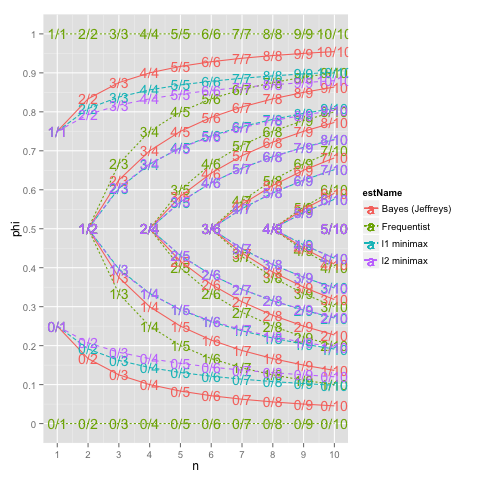

In [6]:
%%R -i df
df = as.data.frame(df)
df$group = as.factor(pmin(df$h,df$n-df$h))
df$up = 2*df$h>=df$n
df$down = 2*df$h<=df$n
pieces = list()
for(e in unique(df$estName)) {
  pieces[[length(pieces)+1]] = 
    geom_text(data=subset(df,estName==e & up),
              aes(x=n,y=phi,group=group,color=estName,label=paste(h,n,sep='/')))
  pieces[[length(pieces)+1]] = 
    geom_line(data=subset(df,estName==e & up),
              aes(x=n,y=phi,group=group,color=estName,linetype=estName))
  pieces[[length(pieces)+1]] = 
    geom_text(data=subset(df,estName==e & down),
              aes(x=n,y=phi,group=group,color=estName,label=paste(h,n,sep='/')))
  pieces[[length(pieces)+1]] = 
    geom_line(data=subset(df,estName==e & down),
              aes(x=n,y=phi,group=group,color=estName,linetype=estName))
}
ns = sort(unique(df$n))
print(ggplot() + pieces + 
      scale_x_continuous(labels=ns,breaks=ns) +
      scale_y_continuous(labels=seq(0,1,0.1),breaks=seq(0,1,0.1))
     )
#write.table(df,file='dfFrame.tsv',sep='\t',row.names=FALSE)
#df <- read.table('dfFrame.tsv',sep='\t',header=TRUE)

# print the decision tables
options(width = 160)
for(eName in unique(df$estName)) { 
   print(eName)
   tab <- xtabs(phi~n+h,data=subset(df,estName==eName))
   for(n in 1:dim(tab)[[1]]) {
     if((n+2)<=dim(tab)[[2]]) { # R doesn't have empty : operator
        for(h in (n+2):dim(tab)[[2]]) {
          tab[n,h] = NA
        }
      }
   }
   print(tab)
}

In [7]:
pTrue = (0.0,0.5,1.0)
for k in range(1,11):
    print('')
    print('uniform Bayes solution to coingame (all-heads, fair, or all-tails):',k)
    bmSoln = bayesMeansEstimates(pTrue,None,k)
    print(bmSoln)
    print('l1 solution to coingame (all-heads, fair, or all-tails):',k)
    l1Soln = solveL1Problem(k,pTrue)
    print('l1Soln',l1Soln)
    print('l1 loss',l1Loss(l1Soln,pTrue))
    print('l2 loss',l2Loss(l1Soln,pTrue))
    def eP(z):
         return bayesMeansEstimates(pTrue,(z, 1-2.0*z, z ),k)[0] - l1Soln[0]
    z = scipy.optimize.brentq(eP,0.0,0.5)
    effectivePriors = (z, 1-2.0*z, z)
    print('effective priors l1',effectivePriors)
    print('Bayes check l1',bayesMeansEstimates(pTrue,effectivePriors,k))
    l2Soln = solveL2Problem(k,pTrue)
    print('l2Soln',l2Soln)
    print('l1 loss',l1Loss(l2Soln,pTrue))
    print('l2 loss',l2Loss(l2Soln,pTrue))
    def gP(z):
         return bayesMeansEstimates(pTrue,(z, 1-2.0*z, z ),k)[0] - l2Soln[0]
    z = scipy.optimize.brentq(gP,0.0,0.5)
    effectivePriors2 = (z, 1-2.0*z, z)
    print('effective priors l2',effectivePriors2)
    print('Bayes check l2',bayesMeansEstimates(pTrue,effectivePriors2,k))




uniform Bayes solution to coingame (all-heads, fair, or all-tails): 1
[ 0.16666667  0.83333333]
l1 solution to coingame (all-heads, fair, or all-tails): 1
l1Soln [0.2499999994549141, 0.750000000545086]
l1 loss 0.2500000005450859
l2 loss 0.06250000027254296
effective priors l1 (0.25000000054508587, 0.49999999890982827, 0.25000000054508587)
Bayes check l1 [ 0.25  0.75]
l2Soln [ 0.25  0.75]
l1 loss 0.25
l2 loss 0.0625
effective priors l2 (0.25, 0.5, 0.25)
Bayes check l2 [ 0.25  0.75]

uniform Bayes solution to coingame (all-heads, fair, or all-tails): 2
[ 0.1  0.5  0.9]
l1 solution to coingame (all-heads, fair, or all-tails): 2
l1Soln [0.16666665684857954, 0.5000000000000001, 0.8333333431514206]
l1 loss 0.16666667157571033
l2 loss 0.05555555882825135
effective priors l1 (0.25000001104535186, 0.4999999779092963, 0.25000001104535186)
Bayes check l1 [ 0.16666666  0.5         0.83333334]
l2Soln [ 0.20710678  0.5         0.79289322]
l1 loss 0.207106781187
l2 loss 0.0428932188135
effective pri

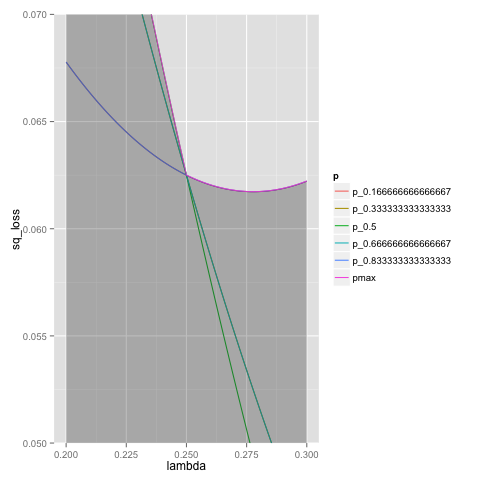

In [8]:
%%R
d <- data.frame(lambda=seq(.2,.3,0.001))
pseq <- seq(1/6,5/6,1/6)
sqErrP <- function(lambda,p) { p*(1-lambda-p)^2 + (1-p)*(lambda-p)^2 }
sqErrM <- function(lambda) { max(sapply(pseq,function(p) sqErrP(lambda,p))) }
lossM <- sapply(pseq,function(p) { sqErrP(d$lambda,p)})
colnames(lossM) <- paste('p',pseq,sep='_')
d <- cbind(d,lossM)
d$pmax <- sapply(d$lambda,sqErrM)
dplot <- melt(d,id.vars=c('lambda'),variable.name='p',value.name='sq_loss')
print(ggplot() +
   geom_line(data=dplot,aes(x=lambda,y=sq_loss,color=p)) +
   geom_ribbon(data=subset(dplot,p=='pmax'),aes(x=lambda,ymin=0,ymax=sq_loss),alpha=0.3) +
   coord_cartesian(ylim = c(0.05,0.07)))

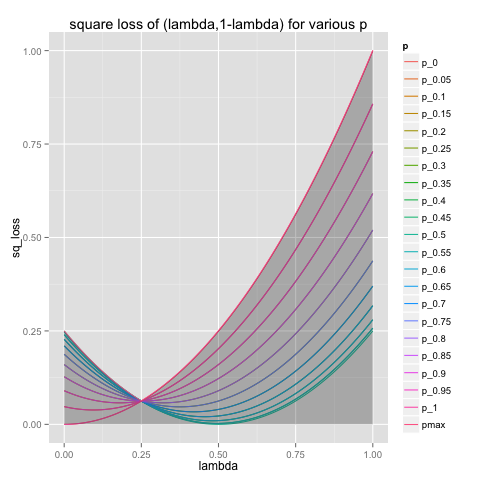

In [9]:
%%R
# l2 all crossing
d <- data.frame(lambda=seq(0,1,0.01))
pseq <- seq(0,1,0.05)
sqErrP <- function(lambda,p) { p*(1-lambda-p)^2 + (1-p)*(lambda-p)^2 }
sqErrM <- function(lambda) { max(sapply(pseq,function(p) sqErrP(lambda,p))) }
lossM <- sapply(pseq,function(p) { sqErrP(d$lambda,p)})
colnames(lossM) <- paste('p',pseq,sep='_')
d <- cbind(d,lossM)
d$pmax <- sapply(d$lambda,sqErrM)
dplot <- melt(d,id.vars=c('lambda'),variable.name='p',value.name='sq_loss')
ggplot() +
   geom_line(data=dplot,aes(x=lambda,y=sq_loss,color=p)) +
   geom_ribbon(data=subset(dplot,p=='pmax'),aes(x=lambda,ymin=0,ymax=sq_loss),alpha=0.3) +
   ggtitle('square loss of (lambda,1-lambda) for various p')

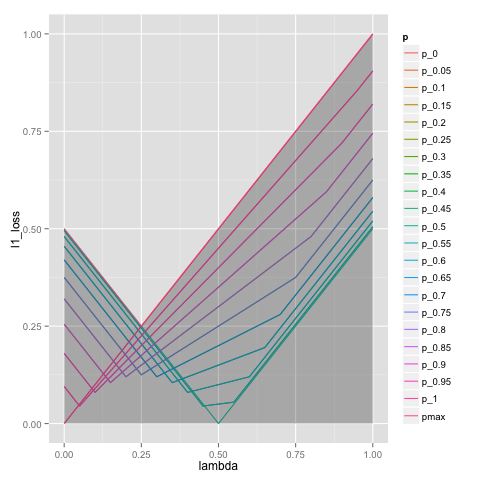

In [10]:
%%R
# l1 error (notice no all-crossing)
d <- data.frame(lambda=seq(0,1,0.01))
pseq <- seq(0,1,0.05)
l1ErrP <- function(lambda,p) { p*abs(1-lambda-p) + (1-p)*abs(lambda-p) }
l1ErrM <- function(lambda) { max(sapply(pseq,function(p) l1ErrP(lambda,p))) }
lossM <- sapply(pseq,function(p) { l1ErrP(d$lambda,p)})
colnames(lossM) <- paste('p',pseq,sep='_')
d <- cbind(d,lossM)
d$pmax <- sapply(d$lambda,l1ErrM)
dplot <- melt(d,id.vars=c('lambda'),variable.name='p',value.name='l1_loss')
ggplot() +
   geom_line(data=dplot,aes(x=lambda,y=l1_loss,color=p)) +
   geom_ribbon(data=subset(dplot,p=='pmax'),aes(x=lambda,ymin=0,ymax=l1_loss),alpha=0.3) 

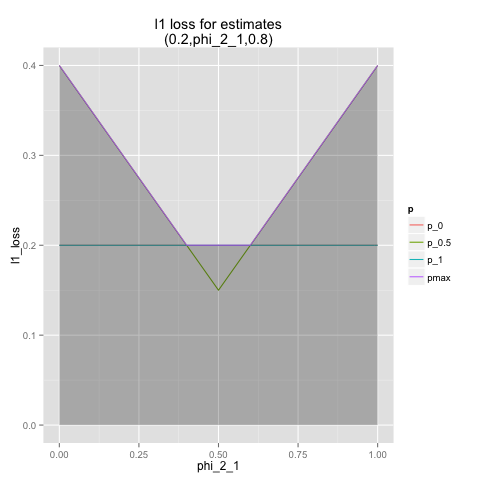

In [11]:
%%R
plotL1Shapes <- function(phis,phiXH,pseq=seq(0,1,1/6),onlyActive=FALSE) {
   d <- data.frame(phiX=seq(0,1,0.01))
   k = length(phis)-1
   combs = sapply(0:k,function(h) choose(k,h))
   phiXname = paste('phi',k,phiXH,sep='_')
   l1ErrP <- function(phiX,p) {
       loss <- 0.0
       for(h in 0:k) {
           if(h!=phiXH) {
              loss = loss + combs[h+1]*p^h*(1-p)^(k-h)*abs(phis[h+1]-p)
           } else {
              loss = loss + combs[h+1]*p^h*(1-p)^(k-h)*abs(phiX-p)
           }
       }
       loss
   }
   l1ErrM <- function(phiX) { max(sapply(pseq,function(p) l1ErrP(phiX,p))) }
   lossM <- sapply(pseq,function(p) { l1ErrP(d$phiX,p)})
   pNames <- paste('p',pseq,sep='_')
   colnames(lossM) <- pNames
   d <- cbind(d,lossM)
   d$pmax <- sapply(d$phiX,l1ErrM)
   if(onlyActive) {
     isActive <- sapply(pNames,function(x) { sum(d[,x]>=d[,'pmax'])>0 })
     keep <- setdiff(colnames(d),pNames[!isActive])
     d <- d[,keep]
   }
   dplot <- melt(d,id.vars=c('phiX'),variable.name='p',value.name='l1_loss')
   vChar <- format(phis,digits=4)
   vChar[phiXH+1] = phiXname
   vName <- paste('l1 loss for estimates\n(',paste(vChar,collapse=','),')',sep='')
   ggplot() +
      geom_line(data=dplot,aes(x=phiX,y=l1_loss,color=p)) +
      geom_ribbon(data=subset(dplot,p=='pmax'),aes(x=phiX,ymin=0,ymax=l1_loss),alpha=0.3) +
      xlab(phiXname) +
      ggtitle(vName)
}

plotL1Shapes(c(0.2, 0.5, 0.8),pseq=c(0,0.5,1),1)

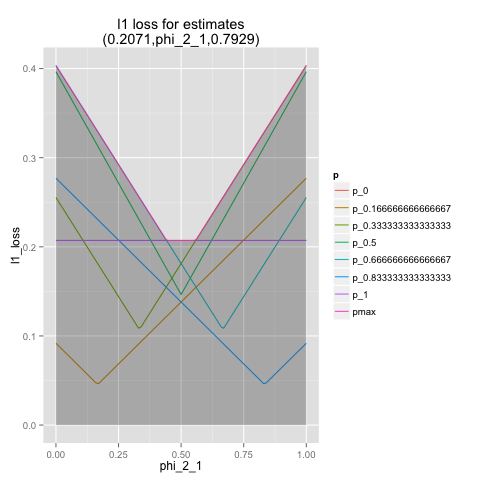

In [12]:
%%R
plotL1Shapes(c(0.20710678118654738, 0.49999999999999983, 0.79289321881345221),1)

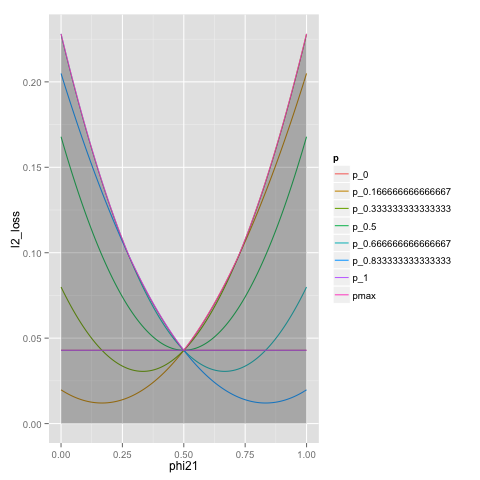

In [13]:
%%R
# l2 no flat
d <- data.frame(phi21=seq(0,1,0.01))
pseq <- seq(0,1,1/6)
l2ErrP <- function(phi21,p) { (1-p)^2*(p-0.207106781187)^2 + 2*p*(1-p)*(phi21-p)^2  + p^2*(p-0.792893218813)^2 }
l2ErrM <- function(phi21) { max(sapply(pseq,function(p) l2ErrP(phi21,p))) }
lossM <- sapply(pseq,function(p) { l2ErrP(d$phi21,p)})
colnames(lossM) <- paste('p',pseq,sep='_')
d <- cbind(d,lossM)
d$pmax <- sapply(d$phi21,l2ErrM)
dplot <- melt(d,id.vars=c('phi21'),variable.name='p',value.name='l2_loss')
ggplot() +
   geom_line(data=dplot,aes(x=phi21,y=l2_loss,color=p)) +
   geom_ribbon(data=subset(dplot,p=='pmax'),aes(x=phi21,ymin=0,ymax=l2_loss),alpha=0.3) 

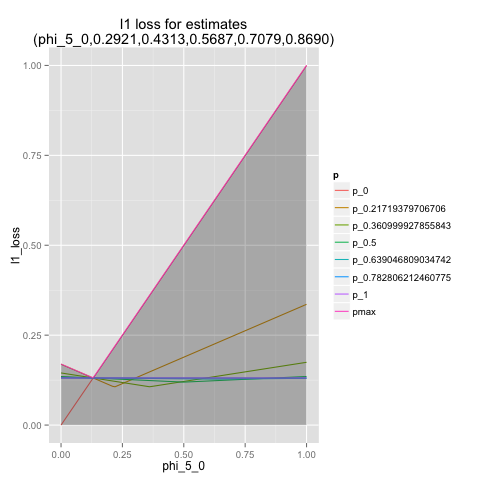

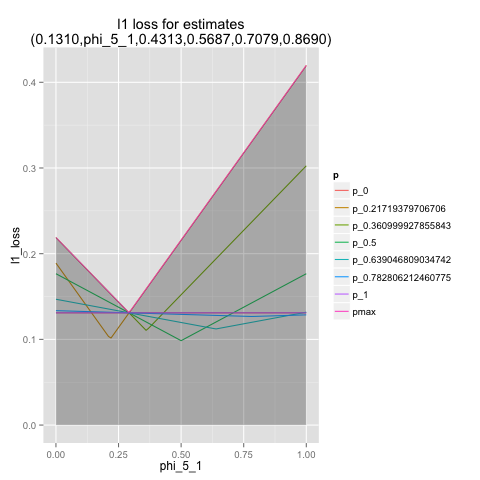

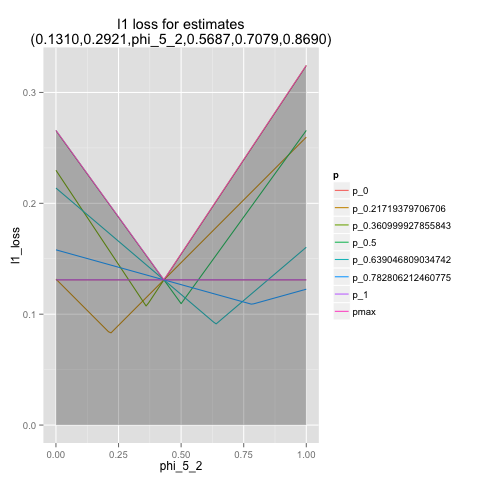

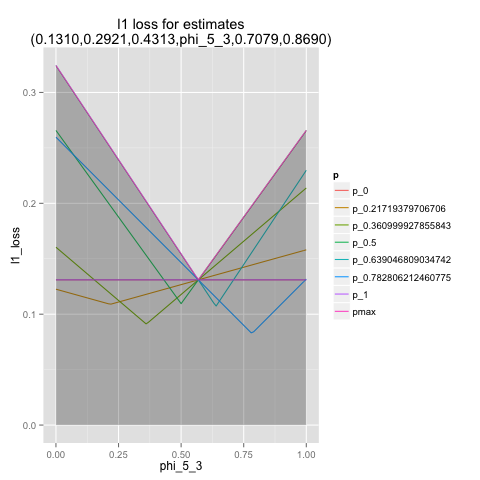

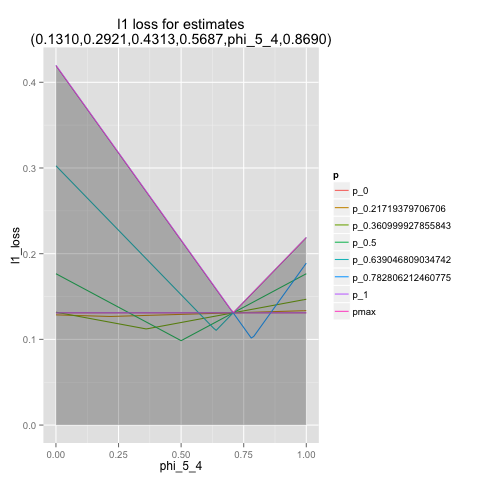

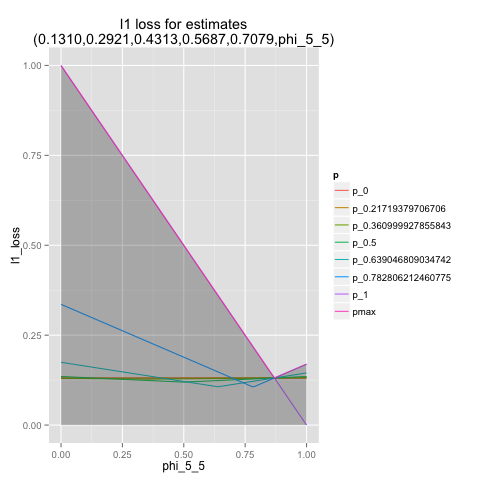

In [14]:
%%R
l1Soln <- c(0.13098490014999317, 0.2920833550225756, 0.4312839988599481, 0.5687160116582426, 0.7079166228922025, 0.8690150999541757)
activePs <- c(0.0, 0.21719379706706049, 0.36099992785584262, 0.5, 0.63904680903474187, 0.78280621246077464, 1.0)
#activePs <- seq(0,1,0.05)
plotL1Shapes(phis=l1Soln,phiX=0,pseq=activePs,onlyActive=TRUE)
for(i in 0:(length(l1Soln)-1)) { 
    print(plotL1Shapes(phis=l1Soln,phiX=i,pseq=activePs,onlyActive=FALSE))
}

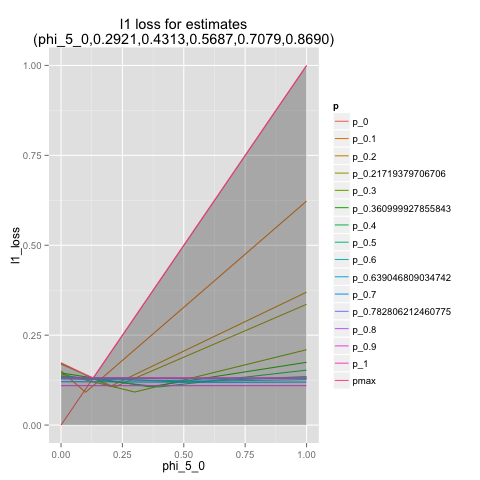

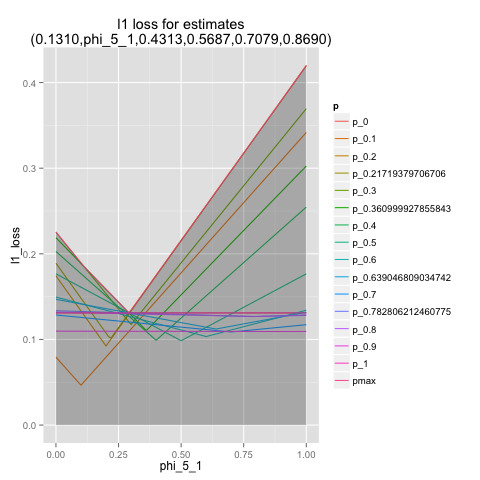

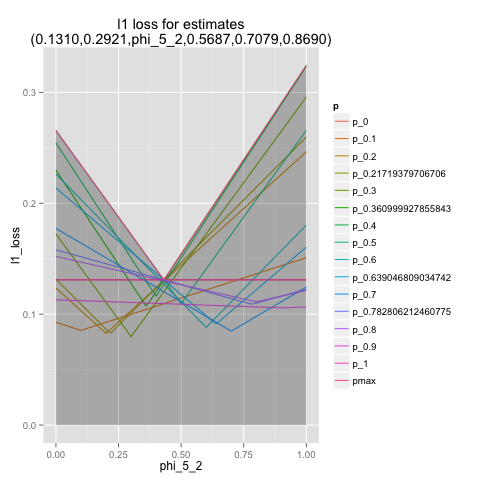

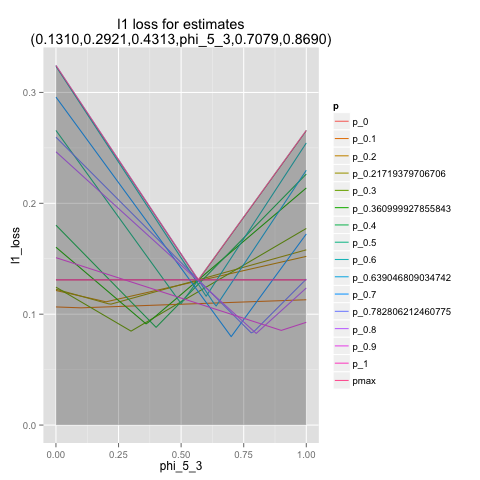

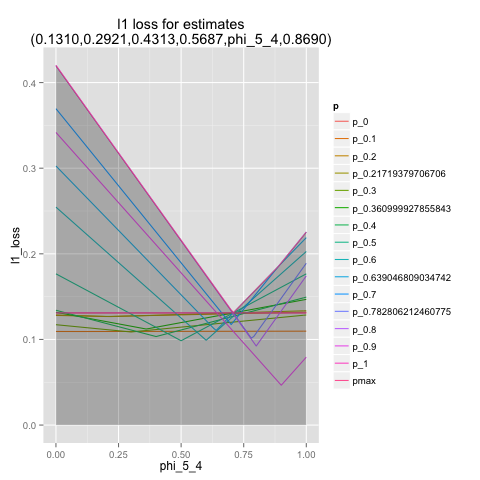

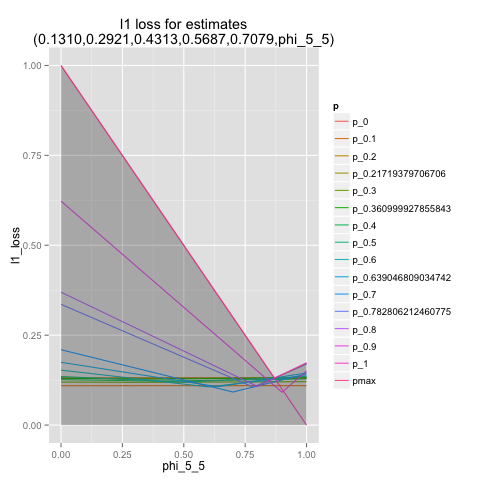

In [15]:
%%R
l1Soln <- c(0.13098490014999317, 0.2920833550225756, 0.4312839988599481, 0.5687160116582426, 0.7079166228922025, 0.8690150999541757)
activePs <- c(0.0, 0.21719379706706049, 0.36099992785584262, 0.5, 0.63904680903474187, 0.78280621246077464, 1.0)
activePs <- sort(union(activePs,seq(0,1,0.1)))
plotL1Shapes(phis=l1Soln,phiX=0,pseq=activePs,onlyActive=TRUE)
for(i in 0:(length(l1Soln)-1)) { 
    print(plotL1Shapes(phis=l1Soln,phiX=i,pseq=activePs,onlyActive=FALSE))
}

In [16]:
# look for general real solutions
def isRealSoln(si):
    return all([abs(complex(sij).imag)<1.0e-6 for sij in si.values()])

# only good for k>=1
def solveKz(k):
   phis = sympy.symbols(['phi' + str(i) for i in range(k+1)])
   z = sympy.symbols('z')
   poly = sum([ sympy.binomial(k,h) * z**h * ((1+z)*phis[h] -z)**2 for h in range(k+1)]) - phis[0]**2 * (1+z)**(k+2)
   polyTerms = poly.expand().collect(z,evaluate=False)
   eqns = [ polyTerms[ki] for ki in polyTerms.keys() if (not ki==1) ]
   solns = sympy.solve(eqns,phis,dict=True)
   solnR = [ si for si in solns if isRealSoln(si)]
   return phis,solnR

p = sympy.symbols('p')
for k in range(1,4):
   print('')
   print(k)
   phis,solnsK = solveKz(k)
   polyK = sum([sympy.binomial(k,h) * p**h * (1-p)**(k-h) * (phis[h]-p)**2 for h in range(k+1) ]) - phis[0]**2
   print('poly',polyK)
   print('number of real solutions:',len(solnsK))
   for solnii in range(len(solnsK)):
        solni = solnsK[solnii]
        print('\t',k,'soln',(solnii+1),solni)
        print('\t latex: \\left(', ','.join([ sympy.printing.latex(solni[phij]) for phij in phis ]),'\\right)')
        print('\tp-free poly check',polyK.subs(solni).expand().simplify())
        print('\tnumeric soln',numericSoln(solni))
        print('')
   print('')




1
poly p*(-p + phi1)**2 - phi0**2 + (-p + 1)*(-p + phi0)**2
number of real solutions: 1
	 1 soln 1 {phi1: 3/4, phi0: 1/4}
	 latex: \left( \frac{1}{4},\frac{3}{4} \right)
	p-free poly check 0
	numeric soln {phi1: 0.75, phi0: 0.25}



2
poly p**2*(-p + phi2)**2 + 2*p*(-p + 1)*(-p + phi1)**2 - phi0**2 + (-p + 1)**2*(-p + phi0)**2
number of real solutions: 2
	 2 soln 1 {phi2: -sqrt(2)/2 + 3/2, phi1: 1/2, phi0: -1/2 + sqrt(2)/2}
	 latex: \left( - \frac{1}{2} + \frac{\sqrt{2}}{2},\frac{1}{2},- \frac{\sqrt{2}}{2} + \frac{3}{2} \right)
	p-free poly check 0
	numeric soln {phi1: 0.5, phi2: 0.7928932188134524, phi0: 0.20710678118654752}

	 2 soln 2 {phi2: sqrt(2)/2 + 3/2, phi1: 1/2, phi0: -sqrt(2)/2 - 1/2}
	 latex: \left( - \frac{\sqrt{2}}{2} - \frac{1}{2},\frac{1}{2},\frac{\sqrt{2}}{2} + \frac{3}{2} \right)
	p-free poly check 0
	numeric soln {phi1: 0.5, phi2: 2.2071067811865475, phi0: -1.2071067811865475}



3
poly p**3*(-p + phi3)**2 + 3*p**2*(-p + 1)*(-p + phi2)**2 + 3*p*(-p + 1)**2*(-p + phi